# Global Recursive LightGBM Time Series Forecasting Guide with the MLForecast Package
## Top 7% Score

In this guide, I'll explain how to create recursive LightGBM time series models to achieve a top 7% score in the retail store sales forecasting competition (as of 2025-06-15) using the MLForecast library.

Gradient boosted decision trees can provde excellent results in timeseries forecasting, but can be tricky to implement. Unlike traditional statistical approaches like ARIMA or additive models (which make reasonable predictions using only date and target variables) decision tree models need many manually created lagged and moving average features to generate accurate predictions.

Another drawback of gradient boosted desicion trees is that they can only predict one point at a time, which isn't ideal for time series forecasting tasks that require predicting multiple time steps into the future. One workaround is to use recursive forecasting: retraining models on the training data plus previously predicted values as you forecast further ahead. This approach can be quite complex to implement correctly. When reviewing other top submissions, I noticed they often required lots of complex code to build competitive models due to this complexity.

Fortunately, the MLForecast library provides a straightforward API for transforming time series data into lagged features and abstracts away much of the recursive modeling infrastructure. This makes building accurate models that make high-quality predictions much more accessible. In this guide, I'll walk through the basics of using LightGBM with the MLForecast library and show you how I used it to achieve a competitive score in the retail store sales forecasting competition.


## What We'll Achieve
- **Final Score**: 0.42052 RMSLE (Top 7%, 60th out of 861 competitors)
- **Key Approach**: Global recursive LightGBM model using holiday and promotion data as exogenous variables.
- **Why This Works**: Instead of thousands of lines of complex recursive forecasting code, MLForecast handles the heavy lifting while we focus on the business logic. We'll beat statistical baselines (AutoETS: ~0.53) with surprisingly simple code.
- **What You'll Learn**:
    - How to set up recursive LightGBM forecasting with very little code using the MLForecast library
    - Which features actually matter for retail forecasting e.g. recent lags, promotions, product family & holidays



### Setup

I use the fastkaggle library to help automate potentially time-consuming tasks like downloading competition data and making submissions. If you would like to find out more, I encourage you to check out Jeremey Howards [useful guide on getting set up in kaggle]( https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners).

In [1]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *


The setup_comp function downloads the data if it hasn't already been downloaded and returns the path object.


In [2]:
comp = 'store-sales-time-series-forecasting'

path = setup_comp(comp)
path

Path('../input/store-sales-time-series-forecasting')

Install non-default packages.

In [3]:
!pip install utilsforecast mlforecast lightgbm statsforecast -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 7.9 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from utilsforecast.plotting import plot_series

from mlforecast import MLForecast
from mlforecast.target_transforms import Differences, LocalStandardScaler
from mlforecast.lag_transforms import ExpandingMean, RollingMean
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from datetime import datetime


import logging

logging.basicConfig(level=logging.INFO)

sns.set_style("whitegrid")

## Loading data

There are 7 datasets included in the competition data:

- train: Training dataset with date, sales, promotion, product family & store info
- test: Mirrors the training dataset for the test period
- sample_submission: An example of the required format for the submission data
- oil: Oil prices over the training and test periods
- holidays_events: Holiday and event information for Ecuador
- stores: Store attributes like city & store cluster (this didn't end up being very useful)
- transactions: Daily units sold during the training period

Adding holiday regressors and promotions to the model made a big improvement, but most of the other datasets weren't very helpful.


In [5]:
# load train, test datasets
train = pd.read_csv(path / "train.csv")
test = pd.read_csv(path / "test.csv")
trans = pd.read_csv(path / "transactions.csv")
holidays = pd.read_csv(path / "holidays_events.csv")
stores = pd.read_csv(path / "stores.csv")
oil = pd.read_csv(path / "oil.csv")
sample_submission = pd.read_csv(path / "sample_submission.csv")

The competition requires us to make time series forecasts for every store-product family combination—in total, that's almost 2000 forecasts!


In [6]:
unique_ts = train.groupby(['store_nbr', 'family']).ngroups
print(f"Number of unique timeseries to forecast: {unique_ts}")
train.sort_values(["store_nbr","family","date"])

Number of unique timeseries to forecast: 1782


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1782,1782,2013-01-02,1,AUTOMOTIVE,2.0,0
3564,3564,2013-01-03,1,AUTOMOTIVE,3.0,0
5346,5346,2013-01-04,1,AUTOMOTIVE,3.0,0
7128,7128,2013-01-05,1,AUTOMOTIVE,5.0,0
...,...,...,...,...,...,...
2993627,2993627,2017-08-11,54,SEAFOOD,0.0,0
2995409,2995409,2017-08-12,54,SEAFOOD,1.0,1
2997191,2997191,2017-08-13,54,SEAFOOD,2.0,0
2998973,2998973,2017-08-14,54,SEAFOOD,0.0,0


## Feature Engineering

MLForecast helps with a lot of the feature engineering but there are a few clean up steps we needto do for the package to work with our data and to help our model get better results. 

The MLForecast expects input data to have a unique_id for each foreacst that we want to make and to have our date and target variable named `ds` and `y` respecitvely.


In [7]:
def create_unique_id(df):
    """Create unique_id based on store_nbr and family grouping."""
    df = df.copy()
    df['unique_id'] = df.groupby(['store_nbr', 'family']).ngroup()
    return df

def rename_for_mlforecast(df):
    """Rename columns to standard forecasting format (ds, y)."""
    return df.rename(columns={
        "date": "ds",
        "sales": "y"
    })




We also want to add some standard time series preprocessing steps like removing negative values, zeros, and missing days.

I haven't included much data analysis in this notebook, but I borrowed many of the preprocessing steps from the excellent work by [Chie Zhen Jie](https://www.kaggle.com/code/chongzhenjie/ecuador-store-sales-global-forecasting-lightgbm), which goes into detail about the relationships between individual features and the target.


In [8]:

def clean_sales_data(df):
    """Clean sales data by ensuring no negative values and replacing zeros."""
    df = df.copy()
    if 'sales' in df.columns:
        df['sales'] = np.maximum(df['sales'], 0)  # Ensure no negative sales
        df['sales'] = df['sales'].replace(0, 0.01)
    return df

def encode_categorical_features(df, categorical_cols, factors=None):
    """
    Encode categorical columns. If factors provided, use them; otherwise create new ones.
    """
    df = df.copy()
    
    if factors is None:
        # Training mode: create new factors
        factors = {}
        for col in categorical_cols:
            if col in df.columns:
                labels, uniques = pd.factorize(df[col])
                factors[col] = dict(zip(uniques, labels))  # Store the mapping
                df[col] = labels
    else:
        # Test mode: use existing factors
        for col in categorical_cols:
            if col in df.columns and col in factors:
                df[col] = df[col].map(factors[col]).fillna(-1)
    
    return df, factors

def create_complete_time_grid(df):
    """Create a complete time grid for all unique_ids across the full date range."""
    date_range = pd.date_range(df.ds.min(), df.ds.max())
    complete_grid = pd.MultiIndex.from_product(
        [df.unique_id.unique(), date_range], 
        names=['unique_id', 'ds']
    ).to_frame(index=False)
    
    # Merge with original data and fill missing values
    df_filled = complete_grid.merge(df, how='left', on=['unique_id', 'ds'])
    return df_filled.fillna(0)

def prepare_base_data(df):
    """Apply common data preparation steps."""
    df = create_unique_id(df)
    df = clean_sales_data(df)
    df["date"] = pd.to_datetime(df.date)
    df = rename_for_mlforecast(df)
    return df

def prepare_train(t):
    """Prepare training data without exogenous variables."""
    X = prepare_base_data(t)
    X = X[["y", "ds", "unique_id"]]
    X_filled = create_complete_time_grid(X)
    return X_filled

def prepare_train_with_exog(t):
    """Prepare training data with exogenous variables."""
    X = prepare_base_data(t)
    exog_cols = ["y", "ds", "unique_id", "onpromotion", "family", 'store_nbr']
    X = X[exog_cols]
    X, factors = encode_categorical_features(X, ["family"])
    X_filled = create_complete_time_grid(X)
    return X_filled, factors

def prepare_test_with_exog(t):
    """Prepare test data with exogenous variables."""
    X = prepare_base_data(t)
    # since we are providing a unique_id, the mlforecast lib will automatically replicate family & store_nbr
    exog_cols = ["ds", "unique_id", "onpromotion"]
    if 'y' in X.columns:
        exog_cols.insert(0, "y")
    X = X[exog_cols]
    return X

def create_complete_date_range(df, date_col):
    """Create a complete date range from min to max date in the dataframe."""
    return pd.date_range(df[date_col].min(), df[date_col].max(), freq='D')

def fill_missing_dates(df, date_col, fill_cols=None):
    """Fill missing dates in a time series dataframe."""
    df = df.copy()
    complete_dates = create_complete_date_range(df, date_col)
    complete_df = pd.DataFrame({date_col: complete_dates})
    df_filled = complete_df.merge(df, on=date_col, how='left')
    return df_filled

def prepare_holidays(hols):
    hols["date"] = pd.to_datetime(hols.date)
    return hols

Before we start building models, it's worth understanding a few key preprocessing concepts that MLForecast requires. The library needs each time series to have a unique identifier (we'll call this unique_id) that combines the store and product family - this tells MLForecast which forecast series each data point belongs to. We also need our date and target columns renamed to ds and y respectively, which is MLForecast's expected format.

One important preprocessing step is handling zeros and negative values in sales data. We replace any negative sales with zero (since negative sales don't make business sense) and convert zero sales to 0.01. This small adjustment helps because some forecasting algorithms struggle with true zeros, and the tiny value maintains the mathematical properties we need for log-scale transformations later.

Creating a complete time grid is another crucial step that often trips up newcomers (aka me, frequently, until I found the problem). MLForecast requires consistent time intervals across all series, so if any store-product combination is missing data for certain dates, we need to fill those gaps with zeros. This ensures every series has the same date range, which is essential for the recursive forecasting to work properly.

For categorical variables like product family, we use pandas' factorize function to convert them to integers. Even though LightGBM can handle strings for categorical variables, the MLForecast library doesn't like them so we need to convert them. We store the mapping so we can apply the same encoding to test data later.

The difference between preparing training and test data is important to understand. Training data preparation is more complex because we have all our historical information available. Test data preparation is simpler since we only include features that will actually be available when making predictions in the real world - we can't use future information that won't exist at prediction time.






In [9]:
X_train = prepare_train(train)
X_train_exog, factors = prepare_train_with_exog(train)

X_train_exog.head()

,unique_id,ds,y,onpromotion,family,store_nbr
0,0,2013-01-01,0.01,0.0,0.0,1.0
1,0,2013-01-02,2.00,0.0,0.0,1.0
2,0,2013-01-03,3.00,0.0,0.0,1.0
3,0,2013-01-04,3.00,0.0,0.0,1.0
4,0,2013-01-05,5.00,0.0,0.0,1.0


In [10]:
holidays_clean = prepare_holidays(holidays)
print(f"Number of holidays: {holidays_clean.description.nunique()}")
holidays_clean.head()

Number of holidays: 103


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


## Preprocess Holidays
There are over 100 holidays in the dataset, and since I'm not from Ecuador, I had no idea which of these would be important predictors and which wouldn't be. To filter them down, I compared the correlations of the holidays with the target variable and filtered out the ones that weren't as strongly related.
I tried a few different thresholds and found that 0.1 seemed to get rid of most holidays that weren't contributing to the model while still keeping the useful ones.


In [11]:
def get_selected_hols(df):
    """Calculates correlations between holidays and sales, used for filtering out redundent hols from model features"""
    correlations = {}

    for holiday in df['description'].unique():
        holiday_indicator = (df['description'] == holiday).astype(int)
        
        correlation = np.corrcoef(holiday_indicator, df['y'])[0, 1]
        correlations[holiday] = correlation

    corr_df = pd.DataFrame(list(correlations.items()), columns=['holiday', 'sales_correlation'])
    corr_df = corr_df.sort_values('sales_correlation', ascending=False)
    selected_holidays = corr_df.loc[abs(corr_df.sales_correlation) > 0.1 ] # the 0.1 threhsold got the best scores after corssvalidating a few cutoffs
    return selected_holidays

hol_sales = pd.merge(X_train, holidays_clean, left_on="ds", right_on="date").query('transferred == False')
plt_df = hol_sales.groupby(["description", "date", "locale"])["y"].sum().reset_index()
selected_hols = get_selected_hols(plt_df)
selected_hols

,holiday,sales_correlation
47,Navidad-2,0.168884
100,Traslado Primer dia del ano,0.152953
77,Terremoto Manabi+2,0.140734
49,Navidad-4,0.131879
48,Navidad-3,0.130318
9,Cantonizacion de Salinas,0.130318
66,Terremoto Manabi+1,0.124679
72,Terremoto Manabi+15,0.124308
46,Navidad-1,0.123238
51,Primer dia del ano,-0.299127


Now that we have the list of holidays we want to include, we can one-hot encode them and fill missing values with 0s so that they're in the right format for modeling.


In [12]:
def add_holidays_vars(X, hols, selected_hols):
    hols["description"] = hols.description.str.replace(r'[.!?,:;"]', '', regex=True)
    merge_hols = pd.get_dummies(hols.loc[(hols.description.isin(selected_hols.holiday)) & (hols.transferred == False)][["date", "description"]])
    merge_hols = merge_hols.drop_duplicates(subset="date")
    X_hols = pd.merge(X, merge_hols, how="left", right_on="date", left_on="ds").drop(columns="date")
    X_hols = X_hols.fillna(0) # days without hols will have nan hol vars
    for col in X_hols.columns:
        if col not in ["ds", "y", "unique_id", "family", "store_nbr", "oil", "store_cluster"]:
            X_hols[col] = X_hols[col].astype("int8")

    X_hols.columns = X_hols.columns.str.replace(" ", "_")
    return X_hols


X_train_holidays = add_holidays_vars(X_train_exog, holidays_clean, selected_hols)
X_train_holidays.head()

,unique_id,ds,y,onpromotion,family,store_nbr,description_Cantonizacion_de_Salinas,description_Navidad,description_Navidad-1,description_Navidad-2,description_Navidad-3,description_Navidad-4,description_Primer_dia_del_ano,description_Terremoto_Manabi+1,description_Terremoto_Manabi+15,description_Terremoto_Manabi+2,description_Traslado_Primer_dia_del_ano
0,0,2013-01-01,0.01,0,0.0,1.0,0,0,0,0,0,0,1,0,0,0,0
1,0,2013-01-02,2.00,0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0
2,0,2013-01-03,3.00,0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0
3,0,2013-01-04,3.00,0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0
4,0,2013-01-05,5.00,0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
X_train_holidays.sort_values("ds")

,unique_id,ds,y,onpromotion,family,store_nbr,description_Cantonizacion_de_Salinas,description_Navidad,description_Navidad-1,description_Navidad-2,description_Navidad-3,description_Navidad-4,description_Primer_dia_del_ano,description_Terremoto_Manabi+1,description_Terremoto_Manabi+15,description_Terremoto_Manabi+2,description_Traslado_Primer_dia_del_ano
0,0,2013-01-01,0.010,0,0.0,1.0,0,0,0,0,0,0,1,0,0,0,0
469264,542,2013-01-01,0.010,0,14.0,17.0,0,0,0,0,0,0,1,0,0,0,0
2481360,150,2013-01-01,0.010,0,18.0,5.0,0,0,0,0,0,0,1,0,0,0,0
470952,543,2013-01-01,0.010,0,15.0,17.0,0,0,0,0,0,0,1,0,0,0,0
2479672,149,2013-01-01,0.010,0,17.0,5.0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012095,1356,2017-08-15,1827.000,8,3.0,42.0,0,0,0,0,0,0,0,0,0,0,0
2013783,1357,2017-08-15,0.010,0,4.0,42.0,0,0,0,0,0,0,0,0,0,0,0
2015471,1358,2017-08-15,376.342,7,5.0,42.0,0,0,0,0,0,0,0,0,0,0,0
1996903,1347,2017-08-15,3.000,0,27.0,41.0,0,0,0,0,0,0,0,0,0,0,0


## Training Models & Cross Validation

In order to know how well our model is performing and identify whether we've made a change that has improved it, we need to cross-validate our models.

First things first, we need to define our error metric. We should use the same metric as the competition so that our results are directly comparable to our submissions. The competition uses Root Mean Squared Log Error, so I'll define this below.


In [14]:

def calculate_rmsle(df, actual_col='actual', predicted_col='predicted'):
    """
    Calculate Root Mean Squared Logarithmic Error (RMSLE) across all forecasts in a DataFrame.
    
    Parameters:
    - df: pandas DataFrame containing the forecast data aggregated by unique_id
    - actual_col: name of the column with actual values
    - predicted_col: name of the column with predicted values
    
    Returns:
    - RMSLE value calculated across all forecasts
    """
    actual = np.array(df[actual_col])
    predicted = np.array(df[predicted_col])
    
    # handle cases where values might be negative (clip at 0)
    actual = np.clip(actual, 0, None)
    predicted = np.clip(predicted, 0, None)
    
    log_actual = np.log1p(actual)       # log1p calculates log(1 + x) more accurately for small x
    log_predicted = np.log1p(predicted)
    
    # apply formula
    squared_log_errors = (log_predicted - log_actual) ** 2
    msle = np.mean(squared_log_errors)
    rmsle = np.sqrt(msle)
    
    return rmsle



Cross-validation for time series is a bit more complicated than for other regression models because time series data has an order that needs to be preserved. That means we can't do regular train-test splits and instead need to measure our errors over different points in our forecast using a sliding window.

MLForecast makes this really easy, and there's a [useful guide](https://nixtlaverse.nixtla.io/mlforecast/docs/how-to-guides/cross_validation.html) on how this works in their documentation.

I decided to train the model on a subset of 100 time series from our training data to speed things up, testing over 5 windows with a step size of 120 days (4 months). That means for each model we test, we'll make 150 forecasts at different seasonal points throughout the year in our training data.


In [15]:
# define cross validation data
subset = 100
X_dataset = X_train
np.random.seed(42)
rand_sub_index = np.random.randint(1, X_dataset.unique_id.nunique(), subset)
x_sub_small = X_dataset[X_dataset['unique_id'].isin(X_dataset['unique_id'].unique()[rand_sub_index])].copy()
horizon = 16
windows = 5
stepsize_days = 120

### Basic Statistical Model

As well as more complex forecasts, Nixtla (the team behind MLForecast) also provides the StatsForecast package, which builds statistical models that act as good baselines through a very similar API. I use Naive Seasonal and AutoETS models here to set a benchmark to beat with our LightGBM model.

There's a lot of important detail packed into not very much code. Here we define the model types and config we want to use in our cross validation. The StatsForecast object trains a seperate model from each timeseries so it can run quite slowly, since we set our time series subset to 100 it needs to create 100 models for both Naive Seasonal and AutoETS for a total of 200.

For statistical models like AutoETS and Seasonal Naive, you need to declare the season length of the most important seasonality to model. In this case, we're making daily predictions and retail data tends to have strong weekly seasonality, so our season_length should be 7. For the StatsForecast object itself, we need to input the frequency of the predictions (in this case D for daily) and the n_jobs parameter to allow parallel training, with -1 meaning use all available threads. It's another nice feature of the Nixtla libraries that they abstract model parallelization.


In [16]:
from statsforecast import StatsForecast
from statsforecast.models import SeasonalNaive, Holt, AutoETS

# define models
s_len = 7 # weekly seasonality, common in retail data
models = [
    SeasonalNaive(season_length=s_len),
   AutoETS(season_length=s_len),
]

sf = StatsForecast(
    models=models,
    freq='D',  # daily frequency
    n_jobs=-1,
)


Now that we have our StatsForecast object, we can call its cross_validation() function to test our models on different windows in the training data, then print the rmsle of the predictions to see how our models are performing.

Again, there are some important variables to define here, like the forecast horizon, stepsize_days, and windows to forecast in the training data. As we discussed before, these variables determine the characteristics of the windows we want to test over in our training data. We use the values we defined earlier. You'll also notice that we only use the subset of our training data that we created earlier in order to reduce the amount of time it takes to train.


In [17]:
cv_results_baseline = sf.cross_validation(
    df=x_sub_small,
    h=horizon,
    step_size=stepsize_days, 
    n_windows=windows,
)
cv_path_baseline = "cv_results_baseline_retrained.csv"
cv_results_baseline.to_csv(cv_path_baseline, index=False)

print(f"AutoETS CV RMSLE:         {calculate_rmsle(cv_results_baseline, actual_col='y', predicted_col='AutoETS'):.4}")
print(f"SeasonalNaive CV RMSLE:   {calculate_rmsle(cv_results_baseline, actual_col='y', predicted_col='SeasonalNaive'):.4}")

AutoETS CV RMSLE:         0.5814
SeasonalNaive CV RMSLE:   0.6852


Lower RMSLE scores indicate better model performance - these baseline scores give us a target to beat with our LightGBM model. RMSLE is particularly useful for sales forecasting because it penalizes underestimating more heavily than overestimating, which makes business sense since it's usually better to have slightly too much inventory than to run out of stock. The log transformation also means the metric focuses on relative rather than absolute errors, so it treats a 10% error the same whether you're predicting sales of 100 units or 1000 units.


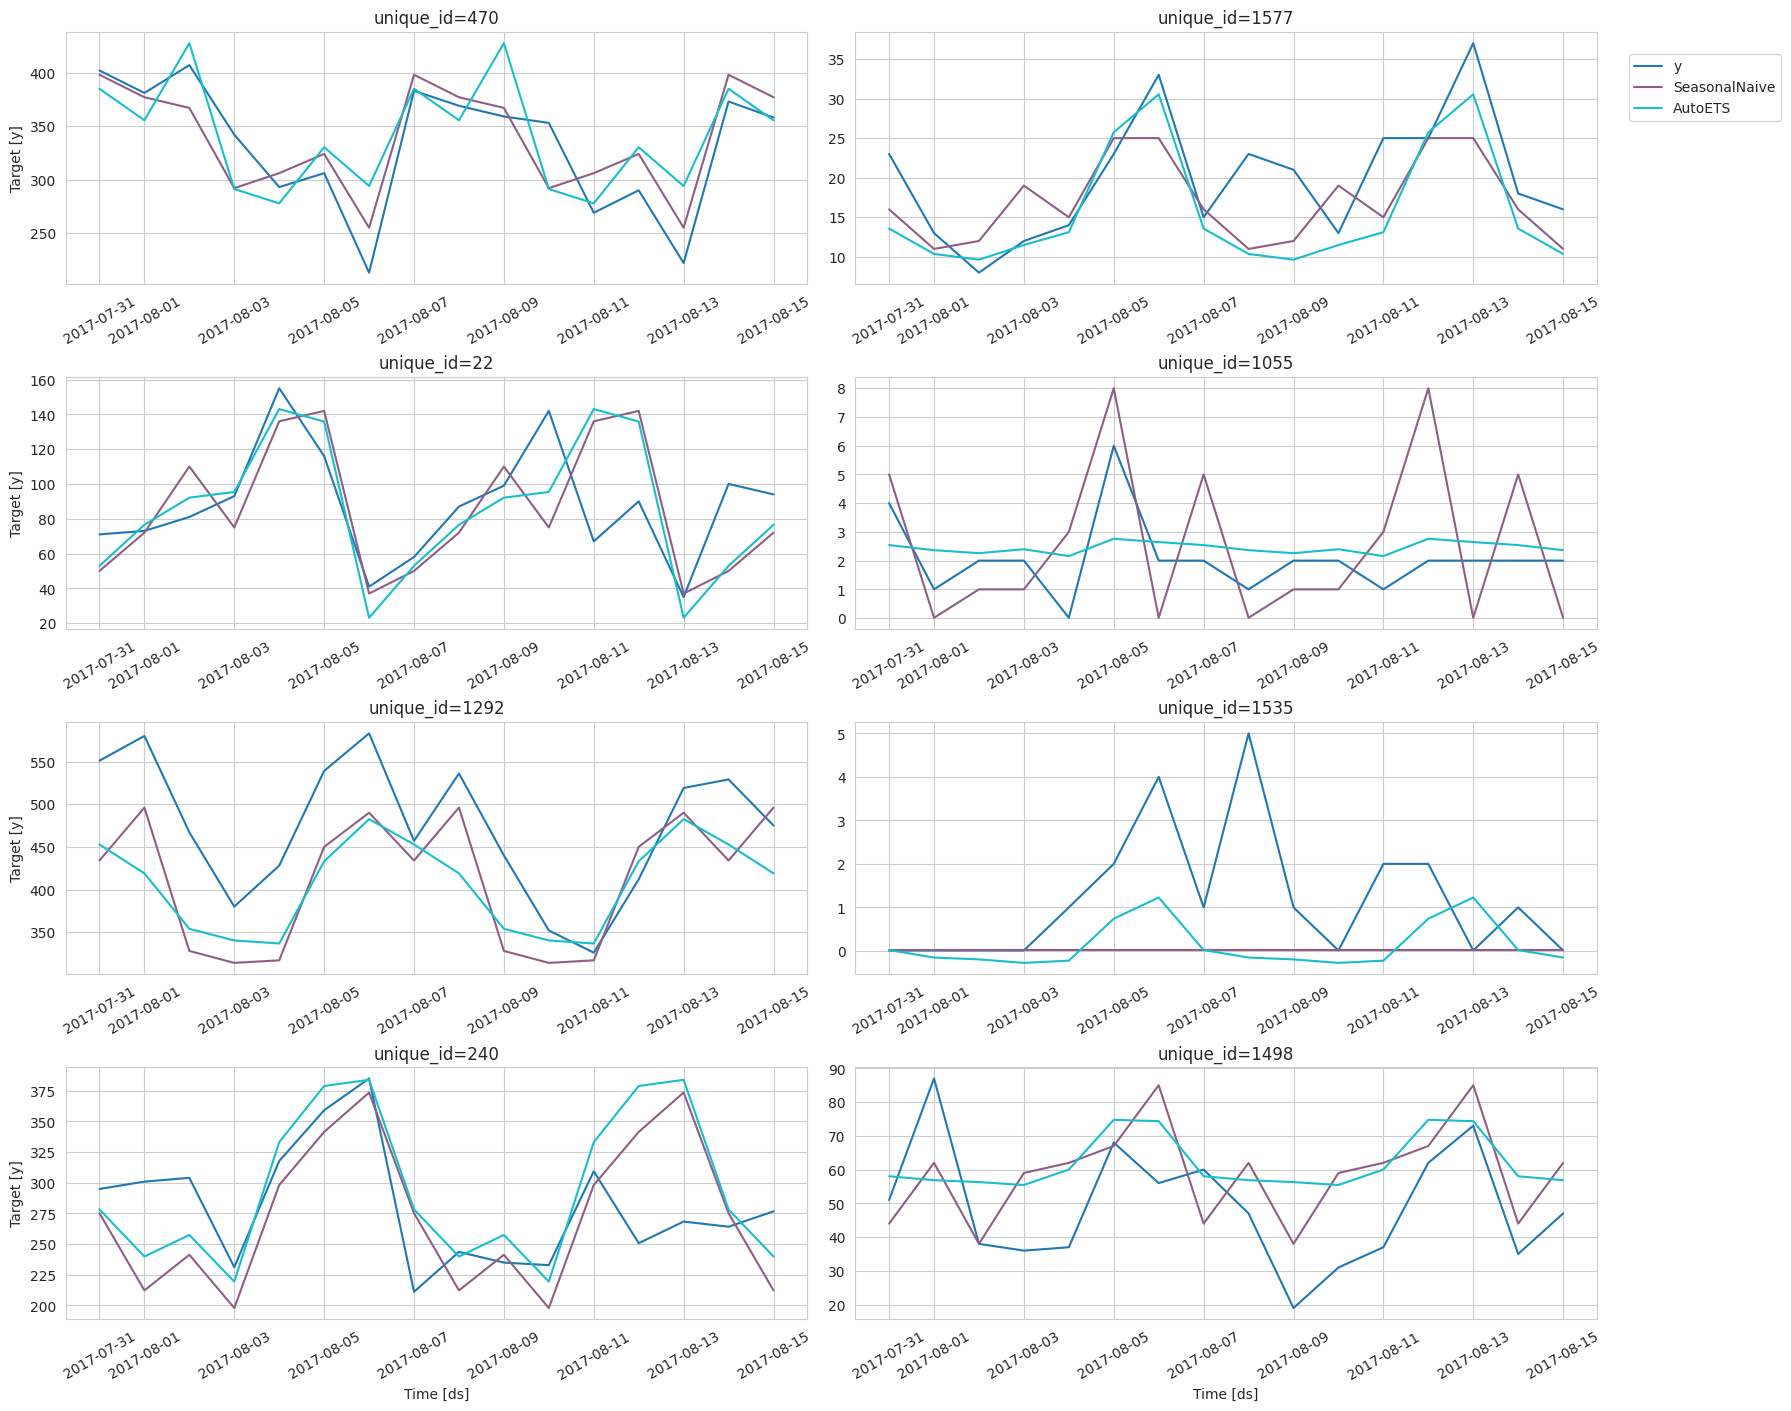

In [18]:
cutoffs = cv_results_baseline.cutoff.unique()
fig = plot_series(forecasts_df=cv_results_baseline.query("cutoff == @cutoffs[-1]").drop(columns='cutoff'))
fig

We can inspect our results reasonably easily using the plot_series() function. Here we can look at our forecast accuracy in the final cutoff we tested over. We can see that our model is making reasonable forecasts most of the time.


### Global Recursive LGBM Model

This LightGBM model represents my best performance after four attempts. It combines one-hot encoded holidays with additional exogenous variables like onpromotion, store_nbr, and product family.

The MLForecast library works differently from StatsForecast. Instead of creating a model for every timeseries, it creates a single global model that is trained on all the time series, rather than training individual models for each one. This is how it makes predictions so fast! To build this model, we create an MLForecast object. Like StatsForecast, it uses a similar API structure and requires the freq parameter, plus some additional configuration.

MLForecast's main strength is automatically generating date and lag features that LightGBM needs. The lags parameter creates features showing what happened 1 day ago, 7 days ago, and so on up to 365 days ago. This helps the model recognize seasonal patterns by learning from historical data at these key intervals.
The lag_transforms parameter captures trend information by applying statistical transformations to our lag features:

- For 1-day lags: ExpandingMean calculates the growing average over time 
- For 7-day and 28-day lags: RollingMean creates moving averages over different windows (7, 28, and 365 days) 

I also add weekday, month end, and month start fields which help the model pick up specific weekly seasonality and payday-related effects.

These transformations help the model understand both short-term fluctuations and long-term trends in the data.


In [19]:
mlf = MLForecast(
    models=[lgb.LGBMRegressor()], 
    freq="d",
    lags=[1, 7, 14, 28, 90, 365],
    target_transforms=[LocalStandardScaler()],    
    lag_transforms={
        1: [ExpandingMean()],
        7: [RollingMean(window_size=7), RollingMean(window_size=28), RollingMean(window_size=365)],
        28: [RollingMean(window_size=7), RollingMean(window_size=28), RollingMean(window_size=365)]
    },
    date_features=["day_of_week", "is_month_end", "is_month_start"],
)
X_dataset = X_train_holidays
x_sub_small_hols = X_dataset[X_dataset['unique_id'].isin(X_dataset['unique_id'].unique()[rand_sub_index])].copy()


A few additional details worth noting: the target_transforms parameter applies LocalStandardScaler to normalize each time series individually, which helps LightGBM handle the huge variation in sales volumes between different store-product combinations. The lag values [1, 7, 14, 28, 90, 365] correspond to key business cycles - yesterday, last week, two weeks, last month, last quarter, and last year. We apply the same rolling window transformations to both 7-day and 28-day lags to give the model multiple perspectives on historical patterns, and we use the same random subset (rand_sub_index) to ensure consistent comparisons across model iterations.


In [20]:
# we have to fit a model before we can display our generated features
static_vars = ["store_nbr", "family"]
mlf.fit(x_sub_small_hols, static_features=static_vars)

# preprocess to show the generated features
preprocessed_features = mlf.preprocess(x_sub_small_hols, static_features=static_vars)

print("\nExample of generated features:")
print(preprocessed_features.info())
preprocessed_features.head()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3550
[LightGBM] [Info] Number of data points in the train set: 125712, number of used features: 30
[LightGBM] [Info] Start training from score 0.124955

Example of generated features:
<class 'pandas.core.frame.DataFrame'>
Index: 125712 entries, 24024 to 2913487
Data columns (total 33 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   unique_id                                125712 non-null  int64         
 1   ds                                       125712 non-null  datetime64[ns]
 2   y                                        125712 non-null  float64       
 3   onpromotion                              125712 non-nul

,unique_id,ds,y,onpromotion,family,store_nbr,description_Cantonizacion_de_Salinas,description_Navidad,description_Navidad-1,description_Navidad-2,...,expanding_mean_lag1,rolling_mean_lag7_window_size7,rolling_mean_lag7_window_size28,rolling_mean_lag7_window_size365,rolling_mean_lag28_window_size7,rolling_mean_lag28_window_size28,rolling_mean_lag28_window_size365,day_of_week,is_month_end,is_month_start
24024,14,2014-01-28,0.239716,0,14.0,1.0,0,0,0,0,...,-0.058491,0.753062,0.369120,-0.080648,-0.355630,-0.184799,-0.098635,1,False,False
24025,14,2014-01-29,0.837623,0,14.0,1.0,0,0,0,0,...,-0.057732,0.753062,0.411828,-0.080648,-0.354775,-0.184799,-0.098635,2,False,False
24026,14,2014-01-30,-0.358192,0,14.0,1.0,0,0,0,0,...,-0.055460,0.496816,0.432968,-0.085563,-0.099383,-0.142091,-0.098635,3,False,False
24027,14,2014-01-31,2.033439,0,14.0,1.0,0,0,0,0,...,-0.056226,0.156009,0.347766,-0.088822,-0.013968,-0.035535,-0.092082,4,True,False
24028,14,2014-02-01,2.033439,0,14.0,1.0,0,0,0,0,...,-0.050949,0.325985,0.390260,-0.085563,0.156009,-0.014182,-0.100273,5,False,True


As you can see, MLForecast has automatically generated 33 features from our original 6 columns. The key additions include:

- Lag features (lag1, lag7, lag14, etc.) showing historical sales values
- Rolling means with different window sizes to capture trends
- Expanding mean for the 1-day lag to show growing averages
- Date features like day_of_week, is_month_end, and is_month_start
- Holiday features (all the description_ columns from our one-hot encoded holidays)

This demonstrates how MLForecast transforms simple time series data into the rich feature set that LightGBM needs to make accurate predictions - no manual feature engineering required!RetryClaude can make mistakes. Please double-check responses.

In [21]:
cv_results_lgbm = mlf.cross_validation(
    df=x_sub_small_hols,
    h=horizon,
    step_size=stepsize_days,  
    n_windows=windows,
    static_features=static_vars,
)
print(f"""\nLGBM RMSLE: {calculate_rmsle(cv_results_lgbm, actual_col="y", predicted_col='LGBMRegressor')}""")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3511
[LightGBM] [Info] Number of data points in the train set: 77600, number of used features: 26
[LightGBM] [Info] Start training from score 0.150670
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3526
[LightGBM] [Info] Number of data points in the train set: 89240, number of used features: 29
[LightGBM] [Info] Start training from score 0.141240
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

0.53 isn't great, but as we'll see, the forecasts tend to perform better on the test set than they do over the whole time series. It is, however, better than the baseline models and (crucially) low enough to get us a decent position on the leaderboard.

I also experimented with more complex feature engineering approaches like adding oil prices into the model, using lagged promotion features, and LightGBM hyperparameter tuning, but these added lots of complexity and either only contributed marginal improvements to the model or made it worse.

A few things I haven't tried that could be even better:

- Training individual models for each product family. Different product lines tend to have very different seasonalities, and since MLForecast trains a single global model and uses that to make predictions, training unique models for each product line or product cluster could lead to better predictions.

- Adding forecasted transactions. Since we only have transactions for the training period, we can't input them to the model in the same way as our onpromotion figures, which we know in advance. However, we could forecast them separately and then add them to our sales forecast to see if that helps.



## Create Final Test Prediction Model

Now that we've cross-validated our model and got reasonable results, we can make our test predictions. We'll use the same architecture as our cross-validation model, so first we have to define that. Then, we'll need to create our test set containing all our exogenous variables so that our model can learn to recognize patterns related to holidays and promotions on the test set.


In [22]:
# # I added the optimised features to my defaults from before but it didn't perform well so I used the old features
mlf = MLForecast(
    models=[lgb.LGBMRegressor()], 
    freq="d",
    lags=[1, 7, 14, 28, 90, 365],
    target_transforms=[LocalStandardScaler()],    
    lag_transforms={
        1: [ExpandingMean()],
        7: [RollingMean(window_size=7), RollingMean(window_size=28), RollingMean(window_size=365)],
        28: [RollingMean(window_size=7), RollingMean(window_size=28), RollingMean(window_size=365)]
    },
    date_features=["day_of_week", "is_month_end", "is_month_start"],
)


In [23]:
print("static_vars during training:", static_vars)
mlf.fit(X_train_holidays, static_features=static_vars)

static_vars during training: ['store_nbr', 'family']
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.167601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3566
[LightGBM] [Info] Number of data points in the train set: 2309472, number of used features: 30
[LightGBM] [Info] Start training from score 0.132607


MLForecast(models=[LGBMRegressor], freq=d, lag_features=['lag1', 'lag7', 'lag14', 'lag28', 'lag90', 'lag365', 'expanding_mean_lag1', 'rolling_mean_lag7_window_size7', 'rolling_mean_lag7_window_size28', 'rolling_mean_lag7_window_size365', 'rolling_mean_lag28_window_size7', 'rolling_mean_lag28_window_size28', 'rolling_mean_lag28_window_size365'], date_features=['day_of_week', 'is_month_end', 'is_month_start'], num_threads=1)

Now that we have our trained model, we can look at the feature importances to see if the biggest contributions make sense.

We can see that the 1-day and 7-day lagged sales, as well as the family feature, were the most important features, which seems reasonable.

We can also spot that day_of_week and onpromotion are also important. Taking a look at the feature importances like this can be a great way to understand how the model is working and to get new feature engineering ideas to experiment with.


In [24]:
model = mlf.models_['LGBMRegressor']
feature_importance = model.feature_importances_
feature_names = mlf.ts.features_order_

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)
importance_df.head(10)

,feature,importance
14,lag1,375
1,family,320
15,lag7,265
27,day_of_week,234
0,onpromotion,189
2,store_nbr,157
19,lag365,155
16,lag14,147
17,lag28,132
21,rolling_mean_lag7_window_size7,131


Now we're ready to make our predictions. To do that, we need to create our test data features, which involves applying a lot of the same preprocessing steps as we did for our training data and joining on our exogenous variables like holidays.

Since we already defined the functions, this is similar to what we did with the training data.


In [25]:
X_test_holidays = add_holidays_vars(prepare_test_with_exog(test), holidays, selected_hols=selected_hols)
X_test_holidays.head()

/tmp/ipykernel_13/1763645577.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_hols = X_hols.fillna(0) # days without hols will have nan hol vars


,ds,unique_id,onpromotion,description_Cantonizacion_de_Salinas,description_Navidad,description_Navidad-1,description_Navidad-2,description_Navidad-3,description_Navidad-4,description_Primer_dia_del_ano,description_Terremoto_Manabi+1,description_Terremoto_Manabi+15,description_Terremoto_Manabi+2,description_Traslado_Primer_dia_del_ano
0,2017-08-16,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2017-08-16,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2017-08-16,2,2,0,0,0,0,0,0,0,0,0,0,0
3,2017-08-16,3,20,0,0,0,0,0,0,0,0,0,0,0
4,2017-08-16,4,0,0,0,0,0,0,0,0,0,0,0,0


Now we can use our trained model to make predictions on the test dataset. We need to make sure that we clip our model predictions here in the same way as we did during cross-validation.


In [26]:
X_test_final = X_test_holidays
final_forecast = mlf.predict(h=horizon, X_df=X_test_final)
prediction_col = 'LGBMRegressor'
final_forecast[prediction_col] = final_forecast[prediction_col].clip(lower=0)
print(f"Forecast shape: {final_forecast.shape}")
final_forecast.head()

Forecast shape: (28512, 3)


,unique_id,ds,LGBMRegressor
0,0,2017-08-16,4.574342
1,0,2017-08-17,4.042274
2,0,2017-08-18,4.213055
3,0,2017-08-19,5.091384
4,0,2017-08-20,2.847363


Now we have our predictions on the test set!

## Create Submission File

Now that we have our predictions, we need to process them so that they're in the same format that Kaggle is expecting for scoring. This involves joining back on the original record ID column.


In [27]:
sample_submission.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


Here I join our forecasts back to the test data in order to map back to the ID we were given as part of the competition. I then check the shape is correct versus what we would expect and check for missing values in case something went wrong in training.

I also save my predictions locally in case I want to come back to them or conduct any future analysis.


In [28]:
# Create ID mapping and merge with forecasts
id_mapping = train[['store_nbr', 'family']].assign(
    unique_id=lambda x: x.groupby(['store_nbr', 'family']).ngroup()
).drop_duplicates()

forecasts_ready = final_forecast.merge(id_mapping, on='unique_id').assign(
    date=pd.to_datetime(final_forecast['ds'].dt.strftime('%Y-%m-%d'))
)

# Create submission
submission = test.assign(date=pd.to_datetime(test.date)).merge(
    forecasts_ready[['date', 'store_nbr', 'family', 'LGBMRegressor']], 
    on=['date', 'store_nbr', 'family']
)[['id', 'LGBMRegressor']].rename(columns={'LGBMRegressor': 'sales'})

# Validate and save
assert len(submission) == len(test) and submission['sales'].isnull().sum() == 0
submission_path = f'submission.csv'
submission.to_csv(submission_path, index=False)
submission.head()

,id,sales
0,3000888,4.574342
1,3000889,0.010016
2,3000890,3.227027
3,3000891,2247.923200
4,3000892,0.087999


That all looks good so we are ready to submit!

## Submit Notebook to the Competition

Again, with the fastkaggle library, it's really easy to submit our predictions and helps us iterate quickly!


In [29]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli(submission_path, 'initial rn26d 128px', comp)


This notebook got a score of 0.42052, which puts us around 60th in the competition overall. Out of 861 entrants in the competition, that places us in the top 7%! Not bad, especially given how simple our approach and code were—that's the power of the MLForecast package.


## Next Steps For An Even Better Score

 - [ ] **Adding Oil & Lagged Promotion Variables**
    I managed to very marginally beat this score (error metric improvement of about 0.005) by adding oil prices and lagged variables for onpromotion as additional exogenous variables, but these made the code a lot more complicated so I decided to leave them out of this guide. If you want to train an even better model, that's a good place to start.

- [ ] **Adding Forecasted Transactions**
    Since we only have transactions for the training period, we can't input them to the model in the same way as our onpromotion figures, which we know in advance. However, we could forecast them separately and then add them to our sales forecast to see if that helps.

- [ ] **Ensemble Models**

    Most of the top 20 submissions use ensemble models to get even better scores. Methods I saw included training models per family and combining the scores, and training independent LightGBM models trained on different variables/proudct lines models and averaging across them. I didn't have much luck training a bunch of family-level models and combining the predictions, but this could be a good thing to try as well. If anyone has any luck adapting this apporach to work well with ensembles I would love to hear how you did it!



## Key Takeaways

**What Actually Made a Difference to the Score:**
- **Recent lags matter most** - 1-day and 7-day sales history were the top features by far
- **Adding the log1p transformation improved performance by 0.05pp**: This was anunintuitive result for me as decision tree based learners are usually agnostic to target variable normalisation but it made a big imporvement
- **Adding the onpromotion variable as an additional regressor also made a big difference:** It ended up being one of the most important features
- **Holiday engineering pays off** - Filtering holidays by correlation (threshold 0.1) gave meaningful improvements without noise
- **Global models > individual models** - One LightGBM trained on all series outperformed family-specific approaches
- **Simple beats complex** - Adding Oil prices and advanced lag engineering for exoganeous variables added complexity for minimal gains (~0.005 improvement)

**MLForecast's Real Value:**
- Handles recursive forecasting infrastructure so you can focus on business logic
- Automates 90% of time series feature engineering that normally takes hundreds of lines
- Makes competitive forecasting accessible without deep time series expertise

**If You Only Remember Three Things:**
1. Start with statistical baselines (AutoETS/Seasonal Naive) to set your benchmark - make sure you submit as soon as you have a working model to see where your baseline stacks up versus the leaderboard
2. Cross-validate properly with time-aware splits - your local CV should correlate with leaderboard
3. Keep your code/approach as simple as possible for your first submissions so that you can iterate quickly
4. Feature importance analysis can be a great place to get ideas to next experiment in your next iteration and are often better than intuition
   

**What Would I Try Next?**
Ensemble different forecast horizons, adding forecasted transactions, external economic data for Ecuador, or training separate models for high/low volume products.

**If this helped you, please upvote! If you spot any issues or have ideas on how I can improve my apporach or my explanations please let me know in the comments**

In [30]:
if not iskaggle:
    push_notebook(user='tommadden', id='top7pct-recursive-lgbm-timeseries-forecast-guide',
                  title='Top 7% LightGBM Timeseries Forecast',
                  file='top_7pct_recursive_lgbm_guide.ipynb',
                  competition=comp, private=False)
